In [1]:
# gunakan keras 2 untuk support tfjs
# https://keras.io/getting_started/#tensorflow--keras-2-backwards-compatibility
%env TF_USE_LEGACY_KERAS=1
!pip install tensorflowjs

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

env: TF_USE_LEGACY_KERAS=1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [2]:
# 1. Memuat data
# Asumsikan data Anda dalam bentuk berikut
# data = {'text': ["komentar1", "komentar2", ...], 'label': [0, 1, ...]}
data = pd.read_csv('dataset.csv', encoding='utf-8')  # Ganti dengan path ke file dataset Anda

In [3]:
data['label'].value_counts()

,count
label,
0,23233
1,1609


In [4]:
# Pisahkan data berdasarkan label
data_1 = data[data['label'] == 1]
data_0 = data[data['label'] == 0]

# Hitung jumlah data pada masing-masing label
count_1 = len(data_1)
count_0 = len(data_0)

# Jika jumlah data label 0 lebih banyak, lakukan sampling
if count_0 > count_1:
  data_0_sampled = data_0.sample(n=count_1, random_state=42) # random_state untuk reproduksibilitas
  balanced_data = pd.concat([data_1, data_0_sampled], ignore_index=True)
# Jika jumlah data label 1 lebih banyak, lakukan sampling pada data label 1
elif count_1 > count_0:
  data_1_sampled = data_1.sample(n=count_0, random_state=42)
  balanced_data = pd.concat([data_0, data_1_sampled], ignore_index=True)
# Jika jumlah data sudah sama
else:
  balanced_data = pd.concat([data_1, data_0], ignore_index=True)

# Acak data yang telah di-balance
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_data.to_csv('balanced-dataset.csv', encoding='utf-8', index=False)

# Cetak jumlah data setiap label setelah di-balance
print(balanced_data['label'].value_counts())

data = balanced_data

label
1    1609
0    1609
Name: count, dtype: int64


In [12]:
# 2. Preprocessing Teks
# Tokenisasi teks
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['comment'])
sequences = tokenizer.texts_to_sequences(data['comment'])
x_data = pad_sequences(sequences, maxlen=max_len)

# Mengubah label menjadi bentuk numpy array
y_data = np.array(data['label'])

# Simpan vocab
vocab = {}

for word, index in tokenizer.word_index.items():
  vocab[word] = index

import json
with open('vocab.json', 'w') as f:
  json.dump(vocab, f)

In [6]:
# 3. Membangun Model LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [7]:
# 4. Kompilasi dan Pelatihan Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Membagi data menjadi data pelatihan dan validasi
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
81/81 [==============================] - 22s 208ms/step - loss: 0.4512 - accuracy: 0.8030 - val_loss: 0.1355 - val_accuracy: 0.9658
Epoch 2/10
81/81 [==============================] - 13s 167ms/step - loss: 0.1091 - accuracy: 0.9732 - val_loss: 0.0903 - val_accuracy: 0.9736
Epoch 3/10
81/81 [==============================] - 14s 174ms/step - loss: 0.0552 - accuracy: 0.9880 - val_loss: 0.0925 - val_accuracy: 0.9689
Epoch 4/10
81/81 [==============================] - 13s 162ms/step - loss: 0.0317 - accuracy: 0.9934 - val_loss: 0.0960 - val_accuracy: 0.9643
Epoch 5/10
81/81 [==============================] - 13s 163ms/step - loss: 0.0197 - accuracy: 0.9961 - val_loss: 0.0983 - val_accuracy: 0.9674
Epoch 6/10
81/81 [==============================] - 12s 150ms/step - loss: 0.0146 - accuracy: 0.9973 - val_loss: 0.1040 - val_accuracy: 0.9658
Epoch 7/10
81/81 [==============================] - 11s 141ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.1004 - val_accuracy: 0.9627

In [8]:
# 5. Evaluasi Model
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

21/21 [==============================] - 1s 30ms/step - loss: 0.1286 - accuracy: 0.9612
Loss: 0.1286235898733139, Accuracy: 0.9611801505088806


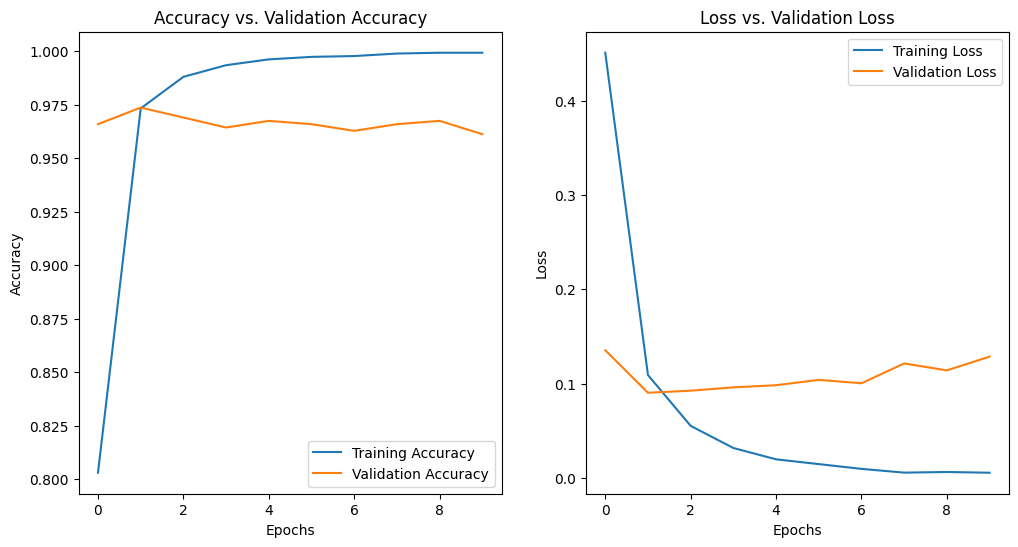

In [9]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
model.save('model.h5')

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
!tensorflowjs_converter --input_format=keras model.h5 model_json

2025-02-15 08:13:27.254462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739607207.279181    2391 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739607207.288469    2391 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!


In [ ]:
from google.colab import files
files.download('model_json/group1-shard1of2.bin')
files.download('model_json/group1-shard2of2.bin')
files.download('model_json/model.json')
files.download('vocab.json')